# Models staking with linear weights optimization over all model  

#### inspired by book [approaching-almost-any-machine-learning-problem](https://github.com/abhishekkrthakur/approachingalmost) and author [Abhishek Thakur](https://www.kaggle.com/abhishek)

In [ ]:
# General libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from functools import partial
# XGB lib
import xgboost as xgb
# sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import gaussian_process
from sklearn import tree
from sklearn import neural_network
from sklearn import model_selection
from sklearn import metrics
# Additional libs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the data
all_data = pd.read_csv('../input/fraud-detection-bank-dataset-20k-records-binary/fraud_detection_bank_dataset.csv', index_col=0)
print(f'The number of features columns is {len(all_data.columns) - 1}')
print()
all_data.head(3)

## Target variable distribution is skewed to normal (not fraud) transaction class

In [ ]:
plt.title('Target variable distribution')
sns.countplot(all_data['targets'])
plt.show();
print('Normal transactions are dominated -> it is expected')

## Let see how generally train / test validation schema looks like 
### For example, let us split data on the 4 parts

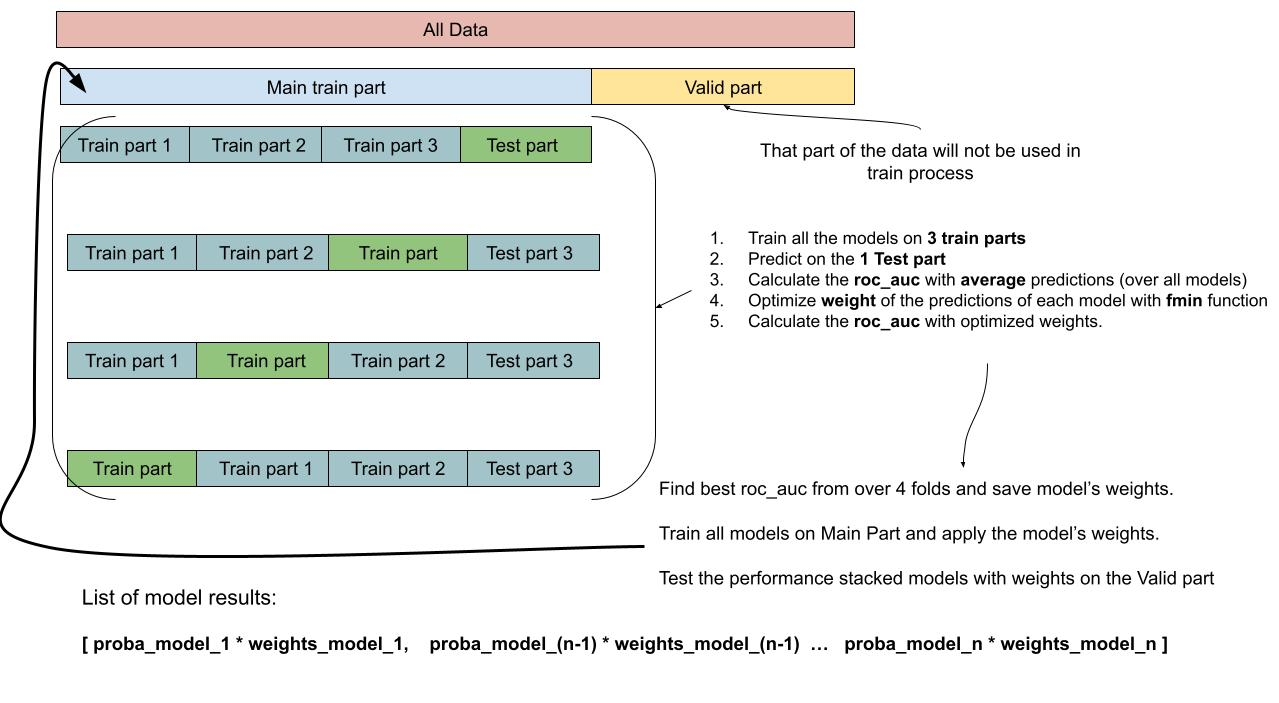

## Let split data on Valid / Train parts and when split Train part on training and testing parts

In [ ]:
# reset index, and replace with current data
all_data.reset_index(drop=True, inplace=True)

# split on Train / Valid part 10%
Train, Valid = model_selection.train_test_split(all_data, test_size=0.1, random_state=11)

# split on Train, Test DO TO 0.5 not
X_train, X_test, y_train, y_test = model_selection.train_test_split(Train.drop('targets', axis=1), Train.targets.values, test_size=0.5, stratify=Train.targets.values, random_state=11)

print(Train.shape, Valid.shape)
assert X_train.shape[0] + X_test.shape[0] + Valid.shape[0] == all_data.shape[0]

## List of models to use (could be more!)

In [ ]:
# List of the models to train 
model_list = [linear_model.LogisticRegression(solver='liblinear', random_state=11),
              neighbors.KNeighborsClassifier(),
              linear_model.SGDClassifier(loss='log', random_state=11),
              tree.DecisionTreeClassifier(random_state=11),
              ensemble.GradientBoostingClassifier(random_state=11),
              ensemble.RandomForestClassifier(random_state=11),
              neural_network.MLPClassifier(random_state=11),
              xgb.XGBClassifier(use_label_encoder=False, verbosity=0, random_state=11)
#               svm.SVC(probability=True),  # too slow, but you can try! 
#               gaussian_process.GaussianProcessClassifier(), # too slow, but you can try!              
             ]

## Class for optimizing ROC_AUC scope

#### We create class that take random coeff (in size of array) multiply by X values and calculate loss (in this case roc_auc)
#### With **fmin** function, we will try to find such `x` where `y` is minimal  ## Class for optimizing ROC_AUC scope

In [ ]:
class OptimizeRocAucScore:
    
    def __init__(self):
        self.coef_ = 0 # set the coeff 0 at the beggining
        
    def calculate_negative_roc_auc(self, coef, X, y):
        # predict the values by multiply all X by coeff 
        predictions = np.sum(X * coef, axis=1)
        # calculate auc score for each prediction
        auc_score = metrics.roc_auc_score(y, predictions)
        # return negative roc_auc to use fmin (i.g. finding max of the function)
        return -1.0 * auc_score
    
    def fit(self, X, y):
        # use partial function to add new arguments, more here https://docs.python.org/3/library/functools.html#functools.partial
        loss_partial = partial(self.calculate_negative_roc_auc, X=X, y=y)
        # set how values  are distributed (could be normal dist -> initial_coef = np.random.normal(np.ones(X.shape[1])))
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)
        # use scipy fmin to minimize the loss function (roc_auc)
        self.coef_ = fmin(loss_partial, initial_coef, disp=True)
        
    def predict(self, X):
        # predict in the same way 
        return np.sum(X * self.coef_, axis=1)

## Short excursus about **fmin** function from scipy.optimize
#### https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html

#### Fmin -> minimize a function using the downhill simplex algorithm.

In [ ]:
# let have a function 
def funct_test(x):
    return x ** 2 + x * 6 - 10

# set the interval of x
interval = range(-12, 8)

# find value there `funct_test` has local minimun. Second argument of fmin for our initial guess (could be wrong)
fmin_result = fmin(funct_test, -1)
print()
plt.rcParams["figure.figsize"] = (6,6)
plt.title(f'This fucntion has local minima when `x` is {fmin_result[0]} and `y` equals to {funct_test(fmin_result[0])}')
plt.plot([i for i in interval], [funct_test(i) for i in interval])
plt.plot(fmin_result[0], funct_test(fmin_result[0]), marker='o', markersize=5, color="red")
plt.show();

### Short excursus to the distribution -> let us draw several of them 

In [ ]:
number_ = 15

plt.rcParams["figure.figsize"] = (6,6)
plt.title('Different distributions over randome variable ')
plt.plot(np.random.dirichlet(np.ones(number_)), linewidth=3, label='dirichlet')
plt.plot(np.random.normal(np.ones(number_)),label='normal')
plt.plot(np.random.exponential(np.ones(number_)),label='exponential')
plt.plot(np.random.gamma(np.ones(number_)),label='gamma')
plt.plot(np.random.poisson(np.ones(number_)),label='poisson')
plt.plot(np.random.uniform(np.ones(number_)),label='uniform')
plt.legend()
plt.show();

### We use distribution to initialize the coefficients as we start a search of best weights in OptimizeRocAucScoreOptimizeRocAucScore class

` initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1) `

#### It is obvious to see that **dirichlet** dist has less variance than others (even normal), but still not flat as uniform. 
#### It might depend on the task (domain knowledge) which distribution to choose. Here it is dirichletdirichlet

more about https://en.wikipedia.org/wiki/Dirichlet_distribution

## Learn best weights of each model

* ### Train all the models on 2 train parts (0.5 split)
* ### Predict on the second part
* ### Calculate the **roc_auc** with average predictions (over all models)

In [ ]:
def calculate_models_predictions(X_train, X_test, y_train, y_test, model_list, print_=False):
    ''' Calculate predicitons (avg probabilities) for each model and return a staked array '''
    avg_pred_ = np.zeros(len(X_test))
    all_predictions = []
    # iterate each model, collect result and divide by the number of models (we have a simple average)
    for index, model in enumerate(model_list):
        pred = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        # add predictions of each model to as 1d array to list.
        all_predictions.append(pred)
        # calculate roc_auc score for each prediction 
        auc = metrics.roc_auc_score(y_test, pred)
        # sum up prediction to calculate later average
        avg_pred_ += pred
        if print_:
            print(f' model # {index} is {str(model_list[index])} and has roc_auc {auc}')
            print()    
    # average all predictions (we have n models, i.g. all_predictions / n)
    avg_pred = avg_pred_ / len(model_list)
    # add prediction as as stacked array -> each column is model results, each raw is features
    all_predictions_staked = np.column_stack((all_predictions))
    # tests
    assert all_predictions_staked.shape == (len(X_test), len(model_list))
    assert len(avg_pred) == len(y_test)
    if print_:
        print()
        print(f' The average roc_auc of all models is {metrics.roc_auc_score(y_test, avg_pred)}')
        
    return all_predictions_staked

all_predictions_staked_train = calculate_models_predictions(X_train, X_test, y_train, y_test, model_list, print_=True)

### Average roc_auc is slightly less than XGB and RandomForest. (note: number can be slightly differently if you run on your cluster)

### Generally, I guess that having average is better than single classifier with the highest score, since each model can grasp something from the data differently and at the end, would be more robust and descriptive to the new data.

* ## We get the predictions in the same way for second part, just changing X_test with X_train

In [ ]:
# Get the predcitions for test part
all_predictions_staked_test = calculate_models_predictions(X_test, X_train, y_test, y_train, model_list, print_=False)

## Let see can we beat them if we find **weights** for each model predictions (not simply average)!

* ### Optimize weight of the predictions of each model with fmin function
* ### Calculate the roc_auc with optimized weights

In [ ]:
def find_optimized_weights(all_predictions_staked_test, all_predictions_staked_train, y_train, y_test):
    opt = OptimizeRocAucScore()
    # fit one fold of average predictions with targets (They have same size)
    opt.fit(all_predictions_staked_test, y_train)
    # predict coeff for each model over another hold
    predict_ = opt.predict(all_predictions_staked_train)
    print(f' predictions is {predict_} with shape {len(predict_)}')
    auc = metrics.roc_auc_score(y_test, predict_)
    print()
    print(f'ROC_AUC is {auc} and OPT coeffs is {opt.coef_} to apply to model weights')
    # return weights
    return opt.coef_

optimized_weights_train = find_optimized_weights(all_predictions_staked_test, all_predictions_staked_train, y_train, y_test)

In [ ]:
# get the weights on the second part
optimized_weights_test = find_optimized_weights(all_predictions_staked_train, all_predictions_staked_test, y_test, y_train)

## We have the best ROC_AUC (0.97+) with `optimized_weights_train` weights 

### Next step we take apply these weights to the model predictions (not as average, as we did before) and test it on Valid part (as we have separated above)

### By this we can really find out performance on the data that has not been used in any train/test processes.

In [ ]:
def calculate_models_predictions_with_weights(Train, Valid, model_list, optimized_weights_train):
    ''' Calculate predicitons with optimized weights for each model
    Train all models on the Train set and calculate roc_auc on Valid Set
    '''
    weighted_pred_ = np.zeros(len(Valid))
    pred_ = np.zeros(len(Valid))
    # iterate over each model, apply weights
    for index, model in enumerate(model_list):
        pred = model.fit(Train.drop('targets', axis=1), Train.targets.values).predict_proba(Valid.drop('targets', axis=1))[:, 1]
        weighted_pred_ += pred * optimized_weights_train[index]
        pred_ += pred 
        
    avg_pred = pred_ / len(model_list)
    
    print(f' The weighted probabilities over all models has roc_auc {metrics.roc_auc_score(Valid.targets.values, weighted_pred_)} on the Valid part')
    print()
    print(f' The Average probabilities over all models has roc_auc {metrics.roc_auc_score(Valid.targets.values, avg_pred)} on the Valid part')

calculate_models_predictions_with_weights(Train, Valid, model_list, optimized_weights_train)

## Weighted model predictions give at least +1% to the metrics on the data that has not been seen by any model! 

### In this little research, we did the following

- ### Trained a number of models on the training data
- ### Found the optimal weights for each model
- ### Stack all the results of each model taking into account the weights of each model
- ### Counted the metric for the **Valid** part

## Our result shows that the simple mean may not be optimal in the process of combining different models and it is necessary to conduct a separate study to find weights for each model for the stacked classifier.



Comments and suggestions are appreciated! about me https://www.linkedin.com/in/volodymyrgavrish/